# CREDENCE -  Credence to Causal Estimates

### Premise. 
Retrospective causal inference methods, like synthetic controls or difference in difference, are widely used to estimate the impact of an intervention where A/B testing is not an option: for example, fee changes or marketing campaigns. The causal effect of an intervention is the difference between the outcome under a treatment and the counterfactual outcome if an alternative treatment (or no treatment) was chosen. The main challenge in retrospective and non-experimental causal inference is that we only observe the outcome under one of the treatment choices while the counterfactual is never observed. Causal inference methods aims to re-create the scenario in which the alternative treatment was chosen i.e. estimating the counterfactual.

### Evaluation. 
Traditional causal inference methods are typically evaluated in two ways: placebo tests and tests on simulated data. Placebo tests check that the treatment effect estimated by a particular method is zero during a period there is actually no intervention: in that situation, the actual should match the counterfactual. Testing on simulated data is limited because the data generative process is often simple and lacks the complexities of real world datasets where the method is actually applied. For applied researchers, the important question is understanding how well a method actually performs in realistic situations, not on a toy dataset.

### Framework. 
In this project, we propose and develop a framework for generating complex and realistic datasets with known treatment effects. This approach combines the best parts of placebo tests and simulation tests: the simulated dataset would have as much complexity as the real world datasets used in placebo tests, but users would be able to control the treatment effect as well as the level of endogeneity like they do in simulation tests.

Thus, generated datasets can then be used to understand the performance of different causal inference methods on various metrics, allowing scientists to choose appropriate method for a given problem. Currently, we focus on causal inference with time-series data using synthetic control method(s). 

Our framework uses a neural network based black-box data generative model called Autoregressive Variational AutoEncoder (AR-VAE), and an interpretable transformation map (ITM) to learn the distribution and sample dataset which have similar dynamics as the real datasets of interest. The AR-VAE model allows us to generate complex data while the ITM allows us to manipulate and intervene on the samples to encode treatment effects. 

Code Commit Link - https://git-codecommit.us-east-1.amazonaws.com/v1/repos/credence

### Prerequisite python libraries
Numpy, Math, Pytorch, Pytorchvision, Pytorch-lightning, Pandas, Matplotlib, Sys, OS, sbibm

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Add path for repo
import os
import sys
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split

sys.path.append(os.path.abspath('../python'))
import train_arvae
import verify_causal_model

from train_arvae import exclude_small_targets, prepare_input, generate_example_sample
from train_arvae import rescale, convert_to_2d
from sbibm.metrics.mmd import mmd
from validate_arvae import c2st_new

## How to use CREDENCE

### Fetch Training Data
Read training data and store it in form (T,B,N) where T is the number of time steps, B is the number of units, N is the number of time-series in a unit.

In [3]:
import dill
input_file = '../data/traindata_US_referral_V1_rm_zero.pkl'
# This file can be downloaded from s3://sdg-credence/data/referral_V1/processed_pkl/traindata_US_referral_V1_rm_zero.pkl
with open(input_file, 'rb') as file:
    data_input = dill.load(file)
data_input.shape

(1095, 1892, 52)

In [4]:
B=data_input.shape[1]
N=52
T = data_input.shape[0] #length timeseries
targets = 2
adjust = 10

import dill
in_file = '../data/traindata_US_referral_V1_postprocessed_rm_zero_run2.pkl'
# This file can be downloaded from s3://sdg-credence/data/referral_V1/processed_pkl/traindata_US_referral_V1_postprocessed_rm_zero_run2.pkl
with open(in_file, 'rb') as file:
    data = dill.load(file)
data.shape

(1095, 1892, 52)

In [5]:
data = exclude_small_targets(data = data, targets=targets)
data_norm_orig = prepare_input(data = data, targets=targets, adjust=adjust, outlier_threshold=5)

Shape: (1095, 1760, 52)

Mean of raw data: 274252.651
Std. dev of raw data: 1000561.146

Mean of normalized data: -0.000
Std. dev of normalized data: 0.281


In [6]:
data_norm, data_norm_test = train_test_split(data_norm_orig, test_size=0.2)

### Train ARVAE

##### Set Hyperparameters

In [7]:
hyper_params = {}
hyper_params['epochs'] = 10
hyper_params['kld_weight'] = 5e-06
hyper_params['hidden_dims'] = [512,256,128]
hyper_params['latent_dim'] = 4

###### Running training function

In [8]:
vae_model, runner = train_arvae.train(data_norm, hyper_params, 
                          output_checkpoint_path='ar_vae.ckpt')

Loss Before Training


GPU available: False, used: False
TPU available: None, using: 0 TPU cores


{'loss': tensor(0.0784, grad_fn=<AddBackward0>), 'Reconstruction_Loss': tensor(0.0784, grad_fn=<MseLossBackward>), 'KLD_Loss': tensor(0.0030, grad_fn=<MeanBackward0>), 'KLD_weight': 5e-06}



  | Name          | Type       | Params
---------------------------------------------
0 | encoder       | Sequential | 29.3 M
1 | fc_mu         | Linear     | 516   
2 | fc_var        | Linear     | 516   
3 | decoder_input | Linear     | 640   
4 | decoder       | Sequential | 164 K 
5 | final_layer   | Sequential | 29.2 M
---------------------------------------------
58.7 M    Trainable params
0         Non-trainable params
58.7 M    Total params
/opt/anaconda3/envs/sdg/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


{'avg_val_loss': tensor(0.0784), 'kld_loss': tensor(0.0030), 'reconstruction_loss': tensor(0.0784)}


/opt/anaconda3/envs/sdg/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The validation_epoch_end should not return anything as of 9.1. To log, use self.log(...) or self.write(...) directly in the LightningModule
  warnings.warn(*args, **kwargs)
/opt/anaconda3/envs/sdg/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The {log:dict keyword} was deprecated in 0.9.1 and will be removed in 1.0.0
Please use self.log(...) inside the lightningModule instead.

# log on a step or aggregate epoch metric to the logger and/or progress bar
# (inside LightningModule)
self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
  warnings.warn(*args, **kwargs)
/opt/anaconda3/envs/sdg/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argum

{'avg_val_loss': tensor(0.0707), 'kld_loss': tensor(0.0033), 'reconstruction_loss': tensor(0.0707)}


{'avg_val_loss': tensor(0.0647), 'kld_loss': tensor(0.0034), 'reconstruction_loss': tensor(0.0647)}


{'avg_val_loss': tensor(0.0590), 'kld_loss': tensor(0.0030), 'reconstruction_loss': tensor(0.0590)}


{'avg_val_loss': tensor(0.0504), 'kld_loss': tensor(0.0035), 'reconstruction_loss': tensor(0.0504)}


{'avg_val_loss': tensor(0.0456), 'kld_loss': tensor(0.0038), 'reconstruction_loss': tensor(0.0456)}


{'avg_val_loss': tensor(0.0416), 'kld_loss': tensor(0.0039), 'reconstruction_loss': tensor(0.0416)}


{'avg_val_loss': tensor(0.0382), 'kld_loss': tensor(0.0042), 'reconstruction_loss': tensor(0.0382)}


{'avg_val_loss': tensor(0.0364), 'kld_loss': tensor(0.0046), 'reconstruction_loss': tensor(0.0364)}


{'avg_val_loss': tensor(0.0347), 'kld_loss': tensor(0.0050), 'reconstruction_loss': tensor(0.0347)}


{'avg_val_loss': tensor(0.0330), 'kld_loss': tensor(0.0057), 'reconstruction_loss': tensor(0.0330)}

Loss After Training
{'loss': tensor(0.0330, grad_fn=<AddBackward0>), 'Reconstruction_Loss': tensor(0.0330, grad_fn=<MseLossBackward>), 'KLD_Loss': tensor(0.0057, grad_fn=<MeanBackward0>), 'KLD_weight': 5e-06}


In [15]:
# #Load from check point
# import t_VAE
# vae_model = t_VAE.AR_VAE.load_from_checkpoint(checkpoint_path = 'ar_vae.ckpt',
#                                                       X = torch.tensor(data_norm).float(),
#                                                       latent_dim = hyper_params['latent_dim'] , 
#                                                       hidden_dims = hyper_params['hidden_dims'],
#                                                       kl_weights = hyper_params['kld_weight'],
#                                                          ).float()

In [9]:
### to generate samples from latent space
targets_var = generate_example_sample(vae_model, targets=targets, adjust=adjust,T=T,B=B,N=N)

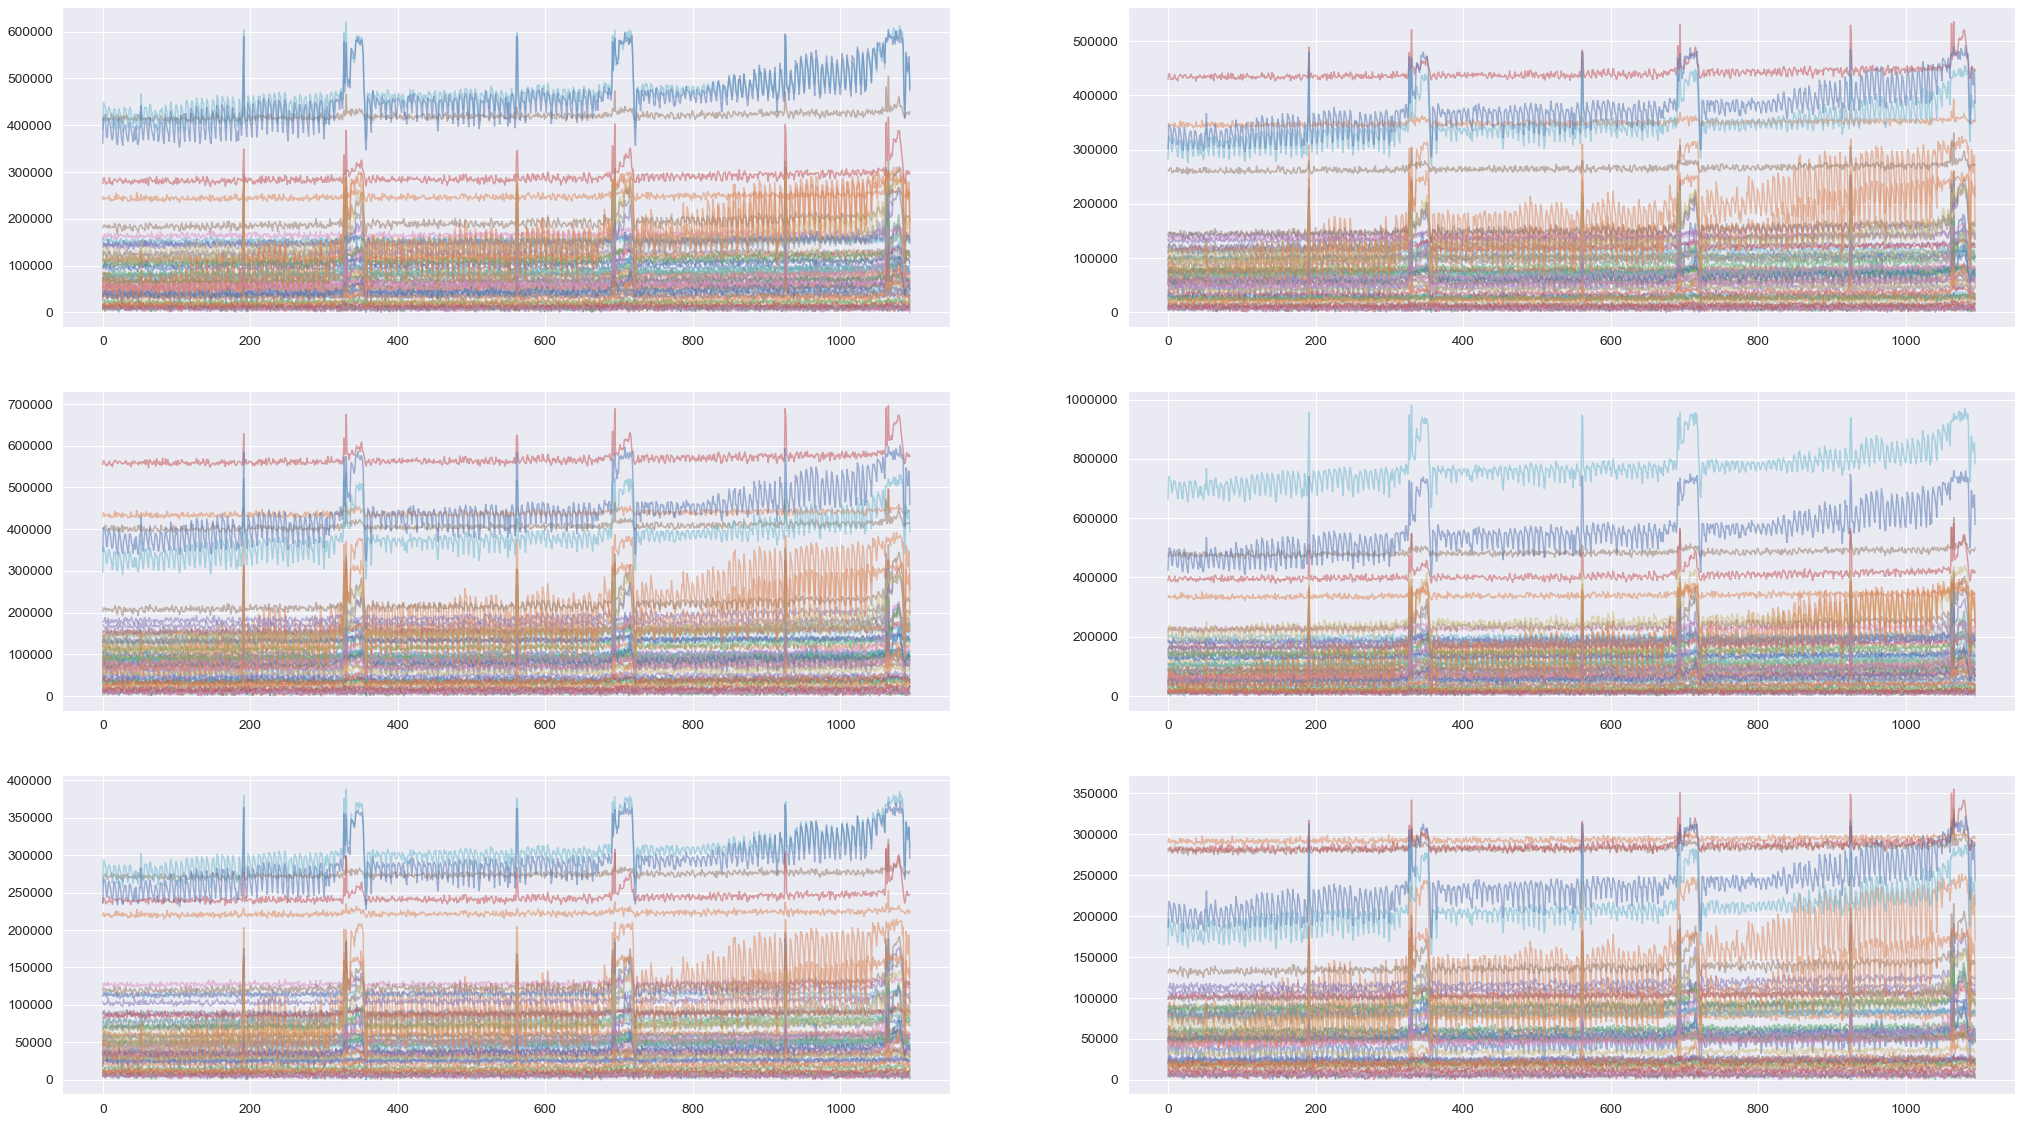

In [10]:
train_arvae.plot_data(vae_model=vae_model, targets=targets, adjust=adjust, T=T, N=N)

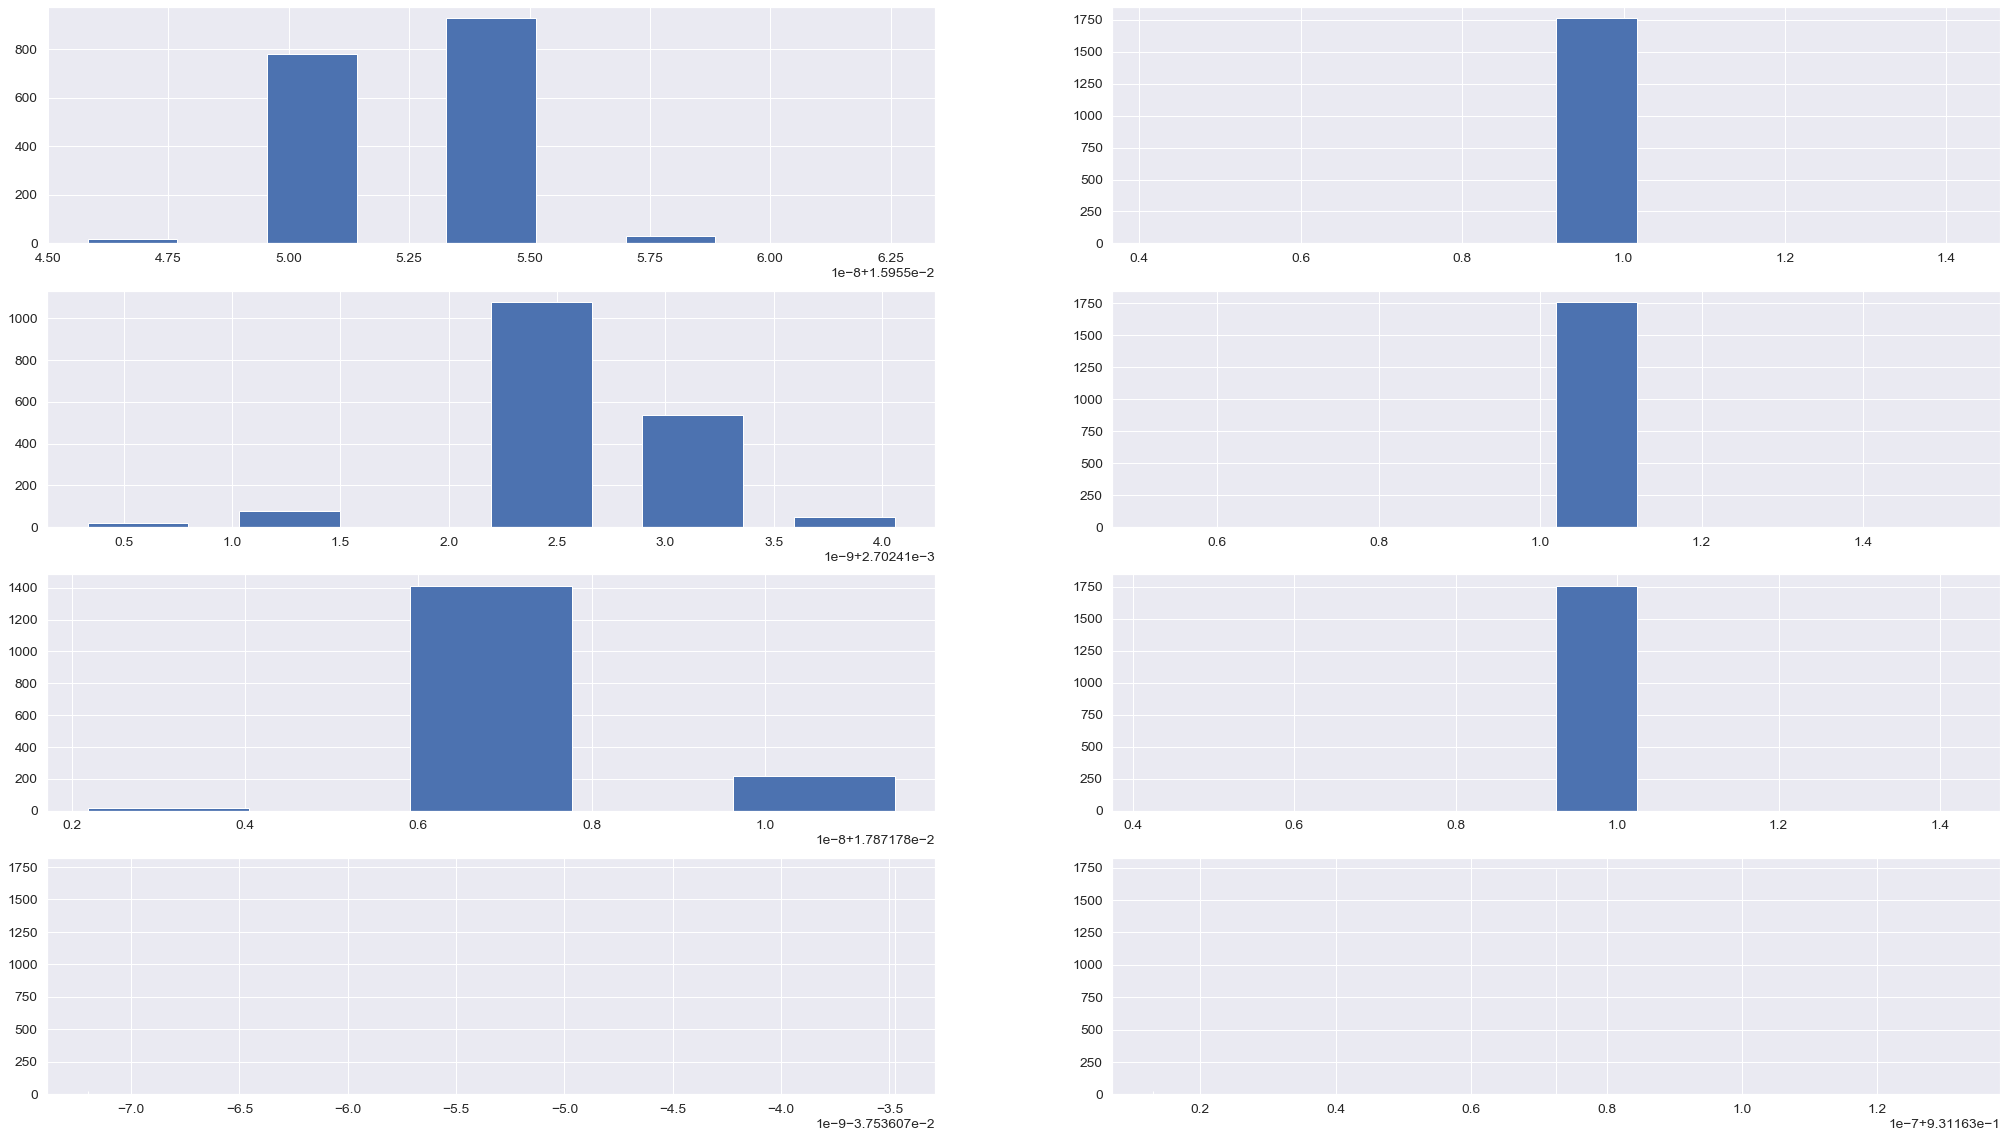

In [11]:
train_arvae.plot_latent_space(vae_model, data_norm_orig)

### Validation

##### Generate reference samples and algorithm samples

In [12]:
B_test = data_norm_test.shape[0]
reference_samples = rescale(data_norm_test, targets=targets ,B=B_test, N=N, T=T, adjust=adjust)
reference_samples = convert_to_2d(reference_samples)
reference_samples = torch.tensor(reference_samples).float()
algorithm_samples = generate_example_sample(vae_model, targets=targets, B=B_test, N=N, T=T, adjust=adjust)
algorithm_samples = convert_to_2d(algorithm_samples)
algorithm_samples=torch.tensor(algorithm_samples).float()

##### Maximum Mean Discrepancy (MMD)

In [13]:
mmd_accuracy = mmd(reference_samples, algorithm_samples)
print("MMD2: ", mmd_accuracy)

MMD2:  tensor(0.1921)


##### C2ST

In [14]:
## c2st
#     reference_samples = torch.tensor(data_norm_orig).float()
c2st_accuracy = c2st_new(reference_samples, algorithm_samples, z_score=False, hidden_layer_sizes=(64,32))
print("C2ST: ", c2st_accuracy)

C2ST:  tensor([0.5666])
